<h1 style='font-size:40px'> NPL Risk Evaluation Modeling</h1>
<div style='font-size:20px'> 
    <ul> 
        <li> 
            This project aims the conceiving of a Machine Learning Model focused on assisting a bank on its credit approval strategy.
        </li>
        <li> 
            The corporation has been scolded for its recent NPL levels by its shareholders. Thus, the executive team has decided that a more conservative 
            credit strategy must be adopted for new contracts.
        </li>
        <li> 
            During the planning meetings, the business team has made two major requests concerning the nature of the model.
            <ul style='list-style-type:decimal'> 
                <li> 
                    It must be focused on predicting whether a given client might produce an NPL in the future.
                </li>
                <li> 
                    The output must be some kind of score suggesting the likelihood of the event to happen. They are not looking for 
                    an incisive "yes or no" answer.
                </li>
            </ul>
        </li>
    </ul>
    <p style='margin-left:30px'> <strong> Note:</strong> The bank's NPL definition is any loan which payment is at least 90 days late.</p>
</div>

<h2 style='font-size:30px'> Data Importing</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The Data Engineers were able to provide two .csv views from the bank's database. The first one contains general information over the clients 
            and the second lists the loans they've contracted over some period of time.
        </li>
    </ul>
</div>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488497 sha256=8eba9a1b9e65f0700389457fdd7c75bd5ebab3c823cccc6e778eee900e17a371
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.core.display import HTML

# Creating the project's SparkSession.
spark = SparkSession.builder.appName('NPL').getOrCreate()

# Also, modifying the session's log level.
log_level = spark.sparkContext.setLogLevel('ERROR')

# This tiny config enables us to scroll along the DataFrame's columns.
display(HTML("<style>pre { white-space: pre !important; }</style>"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 00:07:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<h3 style='font-size:30px;font-style:italic'> Clients Database</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            This dataset is comprised of general information about the loans' clients.
        </li>    
        <li> 
            A particularity worth noting is that date columns show the negative amount of days since the given event took place. Positive numbers 
            indicate the number of days since the occurence ceased to exist - as it might happen with unemployed borrowers in the DAYS_EMPLOYED feature.
        </li>
    </ul>
</div>

In [3]:
path_clients = '/kaggle/input/credit-card-approval-prediction/application_record.csv'

# Defining the data types from the clients dataset.
schema_clients = '''
`ID` STRING, `CODE_GENDER` STRING, `FLAG_OWN_CAR` STRING, `FLAG_OWN_REALTY` STRING, `CNT_CHILDREN` INT,
`AMT_INCOME_TOTAL` FLOAT, `NAME_INCOME_TYPE` STRING, `NAME_EDUCATION_TYPE` STRING, `NAME_FAMILY_STATUS` STRING, `NAME_HOUSING_TYPE` STRING,
`DAYS_BIRTH` INT, `DAYS_EMPLOYED` INT, `FLAG_MOBIL` STRING, `FLAG_WORK_PHONE` STRING, `FLAG_PHONE` STRING, `FLAG_EMAIL` STRING, 
`OCCUPATION_TYPE` STRING, `CNT_FAM_MEMBERS` DOUBLE
'''

# Reading the database with the created schema.
df_clients = spark.read.csv(path_clients, header=True, schema=schema_clients)
df_clients.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|         1

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Duplicates Disclaimer</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
             Clients may not have unique rows in the dataset because the ID column identifies a contracted loan instead of a person.
        </li>
        <li> 
            Thus, I've found convenient for the project to create an ID column that assigns a code for each of the clients.
        </li>
    </ul>
</div>

In [4]:
# Another issue unnoticed by the Data Engineers is that the database contains repeated Loan ID's.
from pyspark.sql.functions import max as ps_max

# Observe that there are Loans mentioned two times. It would be proper to disconsider them. 
data_duplicate_id = (df_clients
                     .groupBy('ID')
                     .count()
                     .filter('`count`>1')
                            )
data_duplicate_id.show(5)

+-------+-----+
|     ID|count|
+-------+-----+
|7742298|    2|
|7174719|    2|
|7091721|    2|
|7089090|    2|
|7022197|    2|
+-------+-----+
only showing top 5 rows



In [5]:
# If we take a peek on the first mentioned ID, we can notice that the presented loan actually is assigned to two different people!

# Thus, the presence of such deals is potentially harmful to our model. It would be sensible to discard such ID's from the database.
df_clients.filter('`ID`==7742298').show()

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|7742298|          F|           N|              Y|           0|        144000.0|         Working|Secondary / secon...|             Widow|House / apartment|    -20626|        -1455|         1|              0|       

In [6]:
# Dropping out the problematic loans.
df_clients = data_duplicate_id.join(df_clients, how='right', on='ID').where('`count` IS NULL').drop('count')

In [7]:
# Listing the `df_clients` features with the exception of ID.
features_clients = df_clients.columns
features_clients.remove('ID')
features_clients

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS']

In [8]:
# Now, getting back to the Client's ID issue, I'd like to present a brief analysis on it.
# Note that the database's actual amount of clients is lower than its number of rows. 
data_clients = df_clients.dropDuplicates(features_clients) 
print(f'`df_clients` length: {df_clients.count()}')
print(f'Number of clients: {data_clients.count()}')

`df_clients` length: 438463


Number of clients: 90084


In [9]:
# We'll assign an ID for every client mentioned in `df_clients`. 
from pyspark.sql.functions import cast, row_number
from pyspark.sql.types import StringType
from pyspark.sql.window import Window

window = Window.orderBy(features_clients)
row_window = row_number().over(window)

# A DataFrame with the clients' data and actual ID.
df_id_clients = data_clients.withColumn('ID_CLIENT', row_window.cast(StringType())).drop('ID')

In [10]:
# We'll need to perform Null Safe JOIN's, since columns such as 'OCCUPATION_TYPE' contain null values.
from functools import reduce

# Creating the multiple null safe JOIN's condition.
condition_id_client = reduce(lambda x,y: x&y, [df_clients[col].eqNullSafe(df_id_clients[col]) for col in features_clients])
columns_join_id = ['df_clients.*', 'df_id_clients.ID_CLIENT'] # Listing the output columns.

# Consolidating the final clients database.
df_clients = (df_clients.alias('df_clients') # Resorting to aliases for both DataFrames present columns with same names.
                 .join(df_id_clients.alias('df_id_clients'), condition_id_client)
                 .select(columns_join_id))
df_clients.show(5)

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|ID_CLIENT|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---------+
|5996382|          F|           N|              N|           0|         28800.0|       Pensioner|Secondary / secon...|           Married|House / apartment|    -20298|       365243|    

<h3 style='font-size:30px;font-style:italic'> Loans Database</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            This table contains the payments records for every loan since its contraction. 
        </li>
        <li> 
            But in order to the dataset be adequate to our project's intent, two transformations are necessary: first, we need to bring the `ID_CLIENT`
            column to it and after that, group the database so that it denounces individuals who've produced an NPL at least once.            
        </li>
    </ul>
</div>

In [11]:
# Bringing the dataset into our notebook.
path_loans = '/kaggle/input/credit-card-approval-prediction/credit_record.csv'
schema_loans = '`ID` STRING, `MONTHS_BALANCE` INT, `STATUS` STRING'
df_loans = spark.read.csv(path_loans, header=True, schema=schema_loans)
df_loans.show(5) 

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
+-------+--------------+------+
only showing top 5 rows



In [12]:
# Now, providing the loans' client ID.
df_loans = df_loans.join(df_clients, ['ID']).select(['ID_CLIENT', 'ID', 'MONTHS_BALANCE', 'STATUS'])
df_loans.show(5)

+---------+-------+--------------+------+
|ID_CLIENT|     ID|MONTHS_BALANCE|STATUS|
+---------+-------+--------------+------+
|    34269|5008810|             0|     C|
|    34269|5008810|            -1|     C|
|    34269|5008810|            -2|     C|
|    34269|5008810|            -3|     C|
|    34269|5008810|            -4|     C|
+---------+-------+--------------+------+
only showing top 5 rows



<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Conceiving the Target Variable</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The `STATUS` column presents a handful of codes that represent distinct status for a loan's payment. Their definition is as follows:
            <table style='font-size:15px;margin-top:20px'> 
                <tr>
                    <th> Code</th>
                    <th> Definition</th>
                </tr>
                <tr> 
                    <td> C</td>
                    <td> Paid off that month</td>
                </tr>
                <tr> 
                    <td> 0</td>
                    <td> 1-29 days past due</td>
                </tr>
                <tr> 
                    <td> 1</td>
                    <td> 30-59 days past due </td>
                </tr>
                <tr> 
                    <td> 2</td>
                    <td> 60-89 days past due </td>
                </tr>
                <tr> 
                    <td> 3</td>
                    <td> 90-119 days past due </td>
                </tr>
                <tr> 
                    <td> 4</td>
                    <td> 120-149 days past due </td>
                </tr>
                <tr> 
                    <td> 5</td>
                    <td> Overdue or bad debts,<p> write-offs for more than 150 days</p> </td>
                </tr>
                <tr> 
                    <td> X</td>
                    <td> No loan for the month</td>
                </tr>
            </table>
        </li>
        <li style='margin-top:20px'> 
            Observe that in our case only the 3, 4 and 5 codes are of our interest. Thus it would be convenient to create a binary flag that denounces whether 
            the individual has ever caused an NPL.
        </li>
    </ul>
</div>

In [13]:
# The dependent variable's conception needs a custom GroupBy that PySpark is unable to perform by itself. Hence, we 
# are going to resort to pandas in this section.
import pandas as pd

# Defining the GroupBy's schema.
schema_flag_npl = '`ID_CLIENT` STRING, `NPL` STRING'

# This lambda expression signs whether a client has ever produced an NPL in the past.
lambda_npl = lambda x: '1' if x.STATUS.isin(['3', '4', '5']).any() else '0'

def has_npl(df:pd.DataFrame)->pd.DataFrame:
    '''
        Verifies if a client's  records contain any sort of Non-Performing Loan.
        
        Parameter
        ---------
        `df`: pd.DataFrame 
            The loan records of a certain client.
        
        Returns
        -------
        A `pd.DataFrame` with the client's ID and a flag indicating NPL existence in their loan history. 
    '''
    output = df.groupby(['ID_CLIENT']).apply(lambda_npl) # `lambda_npl` takes care of the flags creation.
    output.name = 'NPL' # Setting the flag column's name.
    return output.reset_index()

# Finally, generating our target-variable.
target = df_loans.groupBy('ID_CLIENT').applyInPandas(has_npl, schema_flag_npl)

<h2 style='font-size:30px'> Consolidating the Data</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            With both datasets properly treated, we are able to JOIN them in a single table.
        </li>
    </ul>
</div>

In [14]:
# Finally, enriching the clients information with the NPL flag.
df = df_id_clients.join(target, how='inner', on='ID_CLIENT')

In [15]:
#df.write.parquet('/kaggle/input/df-parquet', mode='overwrite')

<h2 style='font-size:30px'> Dataset Splitting</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            With the dataset properly treated, we are able to begin our EDA and model creation. But firstly we have to separate the data in 
            the training and test tables.
        </li>
    </ul>
</div>

In [16]:
# As we can see, we are dealing with an unbalanced dataset case. Thus it is interesting to maintain the target value proportions
# in both training and test sets.
from pyspark.sql.functions import col

df.groupBy('NPL').count().withColumn('proportion', col('count')/df.count()).show()

+---+-----+-------------------+
|NPL|count|         proportion|
+---+-----+-------------------+
|  0| 9509| 0.9774876644736842|
|  1|  219|0.02251233552631579|
+---+-----+-------------------+



In [17]:
# Creating the training and test sets.
train = df.sampleBy('NPL', fractions={'0':.75, '1':.75}, seed=42)
test = df.subtract(train)

In [18]:
# Since the class proportions are relatively proximate, we are able to use them in our project.
print('*** TRAIN ***')
train.groupBy('NPL').count().withColumn('proportion', col('count')/train.count()).show()
print('*** TEST ***')
test.groupBy('NPL').count().withColumn('proportion', col('count')/test.count()).show()

*** TRAIN ***


+---+-----+--------------------+
|NPL|count|          proportion|
+---+-----+--------------------+
|  0| 7205|  0.9785413554257776|
|  1|  158|0.021458644574222464|
+---+-----+--------------------+

*** TEST ***


+---+-----+--------------------+
|NPL|count|          proportion|
+---+-----+--------------------+
|  0| 2308|  0.9800424628450106|
|  1|   47|0.019957537154989383|
+---+-----+--------------------+



In [19]:
# Saving the datasets in distinct .parquet files.
# train.write.parquet('/kaggle/working/train.parquet', mode='overwrite')
# test.write.parquet('/kaggle/working/test.parquet', mode='overwrite')

<h3 style='font-size:30px;font-style:italic'> Defining the Models' Metric</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Providing False Negatives would clearly be more harmful for the bank's equity than False Positives.         
        </li>
        <li> 
            Following conversations with the credit analysts, we've ended up defining the case's official metric
            as an f-score with $\beta=4$. So, we are giving to Recall an importance that is 4x higher than the Precision's.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Exploratory Data Analysis</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            With the data properly segregated, let's briefly analyze its content and see whether we can spot differences 
            among the classes. 
        </li>
    </ul>
</div>

In [20]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [21]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.core.display import HTML

# Creating the project's SparkSession.
spark = SparkSession.builder.appName('NPL').getOrCreate()

# Also, modifying the session's log level.
log_level = spark.sparkContext.setLogLevel('ERROR')

# This tiny config enables us to scroll along the DataFrame's columns.
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [22]:
train = spark.read.parquet('/kaggle/input/npl-train/train.parquet/')
train.show(5)

+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|ID_CLIENT|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|NPL|
+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|      691|          F|           N|              N|           0|         67500.0|         Working|Secondary / secon...|           Married|House / apartment|    -20075|        -7013|         1|   

<h3 style='font-size:30px;font-style:italic'> Assessing the Classes' Incomes</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Let's analyze whether there is any revenue difference between individuals who produced an NPL and those who didn't. 
        </li>
        <li> 
            Since we are dealing with an continuous outcome from two independent samples, I'll use the z-score formula below to examine the 
            income differences:
            <center style='margin-top:20px'> 
                    $z=\frac{\overline{X}_{1}-\overline{X}_{2}}{S_{p}\sqrt{\frac{1}{n_{1}}+\frac{1}{n_{2}}}}$ | $S_{p}=\sqrt{\frac{(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}$
           </center>
        </li>
    </ul>
</div>

In [23]:
# The formula above is only valid for samples with similar std's (0.5<s1/s2<2). So we ought to firstly guarantee that the incomes' std's
# are in accordance to that rule.
df_income_std = train.groupBy('NPL').agg({'AMT_INCOME_TOTAL':'std'})
df_income_std.show()

+---+------------------------+
|NPL|stddev(AMT_INCOME_TOTAL)|
+---+------------------------+
|  0|        99647.7510722535|
|  1|       96639.80531139452|
+---+------------------------+



In [24]:
# Because the std ratio is in the desired interval, we can proceed in using the formula.
list_std = [row['stddev(AMT_INCOME_TOTAL)'] for row in df_income_std.collect()]
list_std[0] / list_std[1]

1.0311253292695148

In [25]:
# By setting our alpha=.05, we can see that there is no statistical evidence that people with no NPL receive higher incomes
# than the other group.
from statsmodels.stats.weightstats import ztest

zeros = [row['AMT_INCOME_TOTAL'] for row in train.select('AMT_INCOME_TOTAL').where('NPL==0').collect()]
ones = [row['AMT_INCOME_TOTAL'] for row in train.select('AMT_INCOME_TOTAL').where('NPL==1').collect()]

ztest(zeros, ones, alternative='larger')[1] # Computing our p-value.

0.7972574858186637

<h3 style='font-size:30px;font-style:italic'> Valuable Assets Analysis</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The dataset contains columns representing whether the client possesses real state or a vehicle.
        </li>
        <li> 
            We can verify if people that own such properties have lower chance of producing an NPL, because they could sell them if they don't have enough 
            cash to pay the loans. 
        </li>
    </ul>
</div>

In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

@udf(returnType=StringType())
def own_valuable(col_car:str, col_realty:str)->str:
    '''
        Signs whether a client possesses a valuable asset that can be sold for paying their loans.
        
        Parameters
        ----------
        `col_car` str
            The value of the flag that indicates the ownership of a car.
        `col_realty`: str
            The value of the flag that indicates the ownership of a real state.
            
        Returns
        -------
        A flag indicating the possession of a car or real state (valuable assets). 
    '''
    if (col_car=='Y') or (col_realty=='Y'):
        return '1'
    return '0'

# Creating the DataFrame that will be used for conducting the Hypothesis Test.
df_valuable = train.select(own_valuable('FLAG_OWN_CAR', 'FLAG_OWN_REALTY').alias('OWN_VALUABLE'), 'NPL')
df_valuable.show(5)

+------------+---+
|OWN_VALUABLE|NPL|
+------------+---+
|           0|  0|
|           0|  0|
|           0|  0|
|           0|  0|
|           0|  0|
+------------+---+
only showing top 5 rows



In [27]:
# Counting the amount of who own or not a valuable asset per target.
gb_valuable = (df_valuable
     .groupBy(['NPL', 'OWN_VALUABLE'])
     .count())

gb_valuable.show()

+---+------------+-----+
|NPL|OWN_VALUABLE|count|
+---+------------+-----+
|  0|           1| 5747|
|  1|           1|  126|
|  0|           0| 1454|
|  1|           0|   46|
+---+------------+-----+



In [28]:
# Now, using `gb_valuable` in order to estimate the proportion of clients with a valuable asset for each target.
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as ps_sum
from pyspark.sql.window import Window

window = Window.partitionBy('NPL')

# It's noticeable that there is a rough 7% difference between the proportions. But can we regard that as statistically significant? 
(gb_valuable
     .withColumn('TOTAL_INSTANCES', ps_sum(col('count')).over(window)) # Total quantity of instances for each target.
     .withColumn('PROP_OWN_VALUABLE', col('count')/ps_sum(col('count')).over(window)) # % of clients who own valuable assets per target.
     .withColumnRenamed('count', 'INSTANCES_WITH_VALUABLE') 
     .where('`OWN_VALUABLE`==1')
     .select(['NPL', 'INSTANCES_WITH_VALUABLE', 'TOTAL_INSTANCES', 'PROP_OWN_VALUABLE'])).show()

+---+-----------------------+---------------+------------------+
|NPL|INSTANCES_WITH_VALUABLE|TOTAL_INSTANCES| PROP_OWN_VALUABLE|
+---+-----------------------+---------------+------------------+
|  0|                   5747|           7201|0.7980835995000695|
|  1|                    126|            172|0.7325581395348837|
+---+-----------------------+---------------+------------------+



In [29]:
# H0: People who honor their debts have the same probability of possessing a valuable asset as the clients in default.
# H1: People who honor their debts have higher probability of possessing a valuable asset compared to clients in default.

# By using the table's data in a Hypothesis Test for proportions, we get a p-value below our significance degree (alpha=.05).

# Therefore, we are able to reject H0 and state we possess sufficient information to say that people who have never produced an NPL have a higher
# tendency of possessing a valuable asset.

from statsmodels.stats.proportion import test_proportions_2indep
test_proportions_2indep(5747, 7201, 126, 172, compare='ratio', alternative='larger').pvalue

0.033767448873365

In [30]:
# With the difference proved real, let's analyze it with the use of a Cohen's h.
from numpy import arcsin, sqrt
def cohen_h(p1:float, p2:float)->float:
    '''
        Computes the Cohen's h coefficient for the difference between two proportions.
        
        Parameters
        ----------
        `p1`: float
            The first probability.
        `p2`: float
            The second probability.
            
        Returns
        -------
        The Cohen's h coefficient for the given proportions.
    '''
    phi1 = 2*arcsin(sqrt(p1))
    phi2 = 2*arcsin(sqrt(p2))
    return phi1-phi2

# By observing the returned h, we can conclude that the difference is of a small magnitude, since it is lower than 0.2.
cohen_h(0.7980835995000695, 0.7325581395348837)

0.15495270778483095

<h3 style='font-size:30px;font-style:italic'> Employment Impact Analysis</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Finally, it would be interesting if we could verify whether unemployment can impair loan payments.  
        </li>
    </ul>
</div>

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Cleaning up Inconsistent Instances</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The dataset contains individuals who present their OCCUPATION_TYPE value as NULL, although they show up as employed (DAYS_EMPLOYED$\leq{0}$)
        </li>
        <li>
            In order to they not be regarded as unemployed clients (who also present OCCUPATION_TYPE as NULL), I thought it would be convenient to assign 
            another category to them.
        </li>
    </ul>
</div>

In [31]:
@udf(returnType=StringType())
def impute_occupation(col_occupation:str, col_days_employed:int)->str:
    '''
        Assigns new categories to the OCCUPATION_TYPE column if it is null for any given row. 
        
        In case the DAYS_EMPLOYED shows that the client is currently employed, we impute 'UNDEFINED'; otherwise, we insert 'UNEMPLOYED'.
        
        Parameters
        ----------
        `col_occupation`: str
            The row's OCCUPATION_TYPE value.
        `col_days_employed`: int
            The row's DAYS_EMPLOYED value.
        
        Returns
        -------
        The row's OCCUPATION_TYPE treated value.
    '''
    # 'Undefined' profession logic.
    if (col_occupation is None) and (col_days_employed<=0):
        return 'Undefined'
    
    # 'Unemployed' logic.
    elif (col_occupation is None) and (col_days_employed>0):
        return 'Unemployed'
    
    else:
        pass
    
    return col_occupation

In [32]:
# `list_select_occupation` will be used so that we can redefine the `train` DataFrame with the transformed OCCUPATION_TYPE feature.
list_select_occupation = train.columns
list_select_occupation.remove('OCCUPATION_TYPE')
list_select_occupation.insert(-1, impute_occupation('OCCUPATION_TYPE', 'DAYS_EMPLOYED').alias('OCCUPATION_TYPE'))
list_select_occupation

['ID_CLIENT',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 Column<'impute_occupation(OCCUPATION_TYPE, DAYS_EMPLOYED) AS OCCUPATION_TYPE'>,
 'NPL']

In [33]:
# Applying the modifications to `train`.
train = train.select(list_select_occupation)
train.show(5)

+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|ID_CLIENT|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|CNT_FAM_MEMBERS|OCCUPATION_TYPE|NPL|
+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|      691|          F|           N|              N|           0|         67500.0|         Working|Secondary / secon...|           Married|House / apartment|    -20075|        -7013|         1|   

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Back to the EDA...</h4>

In [34]:
# Counting the amount of employed and unemployed individuals per target group.
from pyspark.sql.functions import when
(train
     .withColumn('EMPLOYED', when(col('OCCUPATION_TYPE') == 'Unemployed', 0).otherwise(1))
     .groupBy('NPL', 'EMPLOYED')
     .count()
     .orderBy('NPL', 'EMPLOYED')).show(5)

+---+--------+-----+
|NPL|EMPLOYED|count|
+---+--------+-----+
|  0|       0| 1269|
|  0|       1| 5932|
|  1|       0|   31|
|  1|       1|  141|
+---+--------+-----+



In [35]:
# H0: The proportion of unemployed among people with honored debts is the same as with those who didn't.
# H1: The proportion of unemployed among people with honored debts is lower than that of those who didn't.

# By looking at the p-value, we don't have sufficient statistical evidence to reject H0.
test_proportions_2indep(1269, 7201, 31, 172, compare='ratio', alternative='smaller', ).pvalue

0.41442347321737816

In [36]:
# Saving the newly transformed `train` dataset.
train.write.parquet('/kaggle/working/train.parquet', mode='overwrite')

<h2 style='font-size:30px'> Data Transforming </h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            We are very close to begin the creation of our models. But we must remind that the data firstly needs to go under a numeralization procedure.
        </li>
    </ul>
</div>

In [37]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [38]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.core.display import HTML

# Creating the project's SparkSession.
spark = SparkSession.builder.appName('NPL').getOrCreate()

# Also, modifying the session's log level.
log_level = spark.sparkContext.setLogLevel('ERROR')

# This tiny config enables us to scroll along the DataFrame's columns.
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [39]:
train = spark.read.parquet('/kaggle/input/npl-train/train-eda.parquet/')
train.show(5)

+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|ID_CLIENT|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|CNT_FAM_MEMBERS|OCCUPATION_TYPE|NPL|
+---------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|      691|          F|           N|              N|           0|         67500.0|         Working|Secondary / secon...|           Married|House / apartment|    -20075|        -7013|         1|   

<h3 style='font-size:30px;font-style:italic'> Job Labels' Transformer</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>   
            Before making our numeralization process, we must re-implement the 'OCCUPATION_TYPE' column logic that we've written in a formal 
            PySpark Transformer class. In that way, we'll be able to apply the transformations in the test set as well.
        </li>
    </ul>
</div>

In [40]:
from pyspark.ml.param.shared import HasInputCol, HasInputCols, HasOutputCol, HasOutputCols, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark import keyword_only
from pyspark.ml import Transformer
from typing import List

class _BaseTransformer(Transformer, HasInputCol, HasInputCols, HasOutputCol, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    '''
        A class that provide the basic functionalities for the project's custom transformers.
        
        If you consider that your object will require even more customization, you can just overwrite any of the default methods when creating it. Also,
        remember that any extra parameter must be set with a `self._setDefault` method right in the `__init__` function, mentioned in the `self.setParams`
        method and own a getter function.
        
        Lastly, don't forget to define the `_transform` function!
        
        Parameters
        ----------
        `inputCol`: str
            The name of the input column.
        `inputCols`: List[str]
            List containing the name of input columns.
        `outputCol`: str
            The name of the output column.
        `outputCols`: List[str]
            List containing the name of output columns.
        
        References
        ----------
        https://medium.com/@zeid.zandi/utilizing-the-power-of-pyspark-pipelines-in-data-science-projects-benefits-and-limitations-2-2-9063e4bebd05
        https://www.crowdstrike.com/blog/deep-dive-into-custom-spark-transformers-for-machine-learning-pipelines/
    '''
    @keyword_only
    def __init__(self, inputCol:str=None, inputCols:List[str]=None, outputCol:str=None, outputCols:List[str]=None, *args)->None:
        super().__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only
    def setParams(self, inputCol=None, inputCols=None, outputCol=None, outputCols=None): 
        kwargs = self._input_kwargs                                                          
        return self._set(**kwargs)
    
    def setInputCol(self, value):
        return self.setParams(inputCol=value)
    
    def setInputCols(self, value):
        self.setParams(inputCols=value)
    
    def setOutputCol(self, value):
        return self.setParams(outputCol=value)
    
    def setOutputCols(self, value):
        return self.setParams(outputCols=value)

In [41]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

class ImputeOccupation(_BaseTransformer):
    '''
        A Transformer encharged of imputing proper OCCUPATION_TYPE values for rows that are NULL in such column.  
        
        Parameters
        ----------
        `inputCol`: str
            The name of the input column.
            
        Method
        ------
        `_transform`: Applies the mentioned imputation process,
    '''
    @staticmethod
    @udf(returnType=StringType())
    def __impute_occupation(col_occupation:str, col_days_employed:int)->str:
        '''
        Assigns new categories to the OCCUPATION_TYPE column, if it is null. 
        
        In case the row's DAYS_EMPLOYED shows that the client is currently employed, we impute 'UNDEFINED'; otherwise, we insert 'UNEMPLOYED'.
        
        Parameters
        ----------
        `col_occupation`: str
            The row's OCCUPATION_TYPE value.
        `col_days_employed`: int
            The row's DAYS_EMPLOYED value.
        
        Returns
        -------
        The row's OCCUPATION_TYPE treated value.
        '''
        # 'Undefined' profession logic.
        if (col_occupation is None) and (col_days_employed<=0):
            return 'Undefined'

        # 'Unemployed' logic.
        elif (col_occupation is None) and (col_days_employed>0):
            return 'Unemployed'
        
        # Otherwise, it outputs the current value.
        else:
            return col_occupation
    
    def _transform(self, dataset:DataFrame)->DataFrame:
        '''
            Performs the new occupation categories imputation.
            
            Parameter
            ---------
            `dataset`: `pyspark.sql.DataFrame`
                The project's independent variables.
                
            Returns
            -------
            The DataFrame with the treated 'OCCUPATION_TYPE' column.
        '''
        x = self.getInputCol()
        dataset = dataset.withColumn(x, self.__impute_occupation(x, 'DAYS_EMPLOYED'))
        return dataset

<h3 style='font-size:30px;font-style:italic'> String Columns Numeralization</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>   
            The first transformation we must conduct is turning string columns into float format.
        </li>
        <li> 
            As a solution, I'ĺl replace the given category for the its proportion of instances that are defaulted. I think that will be a worthier way 
            of generating numerical information than just providing a One-Hot Encoding.
        </li>
    </ul>
</div>

In [42]:
from pyspark.ml.pipeline import Estimator, Model, Pipeline, PipelineModel
from pyspark.ml.param.shared import HasPredictionCol, Param, Params, TypeConverters
from typing import Dict, List, Union

doc = '''
    Parameter that stores the proportions of defaulted individuals for each X features' categories.
'''
class HasDefaultProportions(Params):
    '''
        A class dedicated to store the categories' proportion of indebted individuals. 
    '''
    defaultProportions:Dict[str, Dict[str, float]] = Param(Params._dummy(), 'defaultProportions', doc)
    
    def __init__(self):
        super(HasDefaultProportions, self).__init__()
    
    def setDefaultProportions(self, value):
        return self._set(defaultProportions=value)
    
    def getDefaultProportions(self):
        return self.getOrDefault(self.defaultProportions)
    
list_col_strings = [col for col, dtype in train.dtypes if dtype=='string' and col !='NPL']

In [43]:
from pyspark.sql.dataframe import DataFrame

class DefaultProportionsModel(Model, HasInputCols, HasDefaultProportions, DefaultParamsReadable, DefaultParamsWritable):
    '''
        The `pyspark.ml.pipeline.Model` that replaces categorical values for their respective proportion of defaulted individuals.
        
        Parameters
        ---------
        `inputCols: List[str]
            A list of the categorical features names.
        `defaultProportions`: Dict[str, DataFrame]
            A dictionary mapping the name of the categorical column to a DataFrame storing the proportions.
            
        Method
        -------
        `_transform`: Performs the replacements.
    '''
    @keyword_only
    def __init__(self, inputCols:List[str]=None, defaultProportions:Dict[str,List[Dict[str, Union[str, float]]]]=None):
        super(DefaultProportionsModel, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only
    def setParams(self, inputCols:List[str]=None, defaultProportions:Dict[str,List[Dict[str, Union[str, float]]]]=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset:DataFrame)->DataFrame:
        '''
            Method that exchanges the categorical values for their proportion of defaulted individuals of the training set.
            
            Parameter
            ---------
            `dataset`: `pyspark.sql.dataframe.DataFrame` 
                A `pyspark.sql.dataframe.DataFrame` with the project's data.
                
            Returns
            -------
            The DataFrame with the mentioned transformation.
        '''
        x = self.getInputCols()
        defaultProportions = self.getDefaultProportions()
        for c in x:
            df = spark.createDataFrame(defaultProportions[c]) # Converting our list of dicts into a DataFrame.
            dataset = dataset.join(df, on=c, how='left').drop(c)
        return dataset

In [44]:
from pyspark.sql.functions import col
from pyspark.sql.types import DecimalType, FloatType

class DefaultProportions(Estimator, HasInputCols, HasDefaultProportions, DefaultParamsReadable, DefaultParamsWritable):
    '''
        An Estimator encharged for measuring the categorical values proportions of defaulted individuals.
    
        Parameter
        ---------
        `inputCols`: List[str]
            A list with the categorical columns names.
            
        Method
        ------
        `_fit`: Measures the proportions and stores them in a DataFrame.
        
        References
        ----------
        https://stackoverflow.com/questions/37270446/how-to-create-a-custom-estimator-in-pyspark
    '''
    @keyword_only
    def __init__(self, inputCols:List[str]=None):
        super(DefaultProportions, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
    
    @keyword_only
    def setParams(self, inputCols:List[str]=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
        
    def setInputCols(self, value:List[str]):
        return self.setParams(inputCols=value)
    
    def setPredictionCol(self, value:str):
        return self.setParams(predictionCol=value)
    
    @staticmethod
    def __measure_proportions(dataset:DataFrame, input_cols:List[str], target:str)->Dict[str, DataFrame]:
        '''
            Responsible for quantifying the categories' proportions of indebted individuals. They will be stored in a `pyspark.sql.dataframe.DataFrame`
            object. Each dataframe is kept in the `defaultedProportions` dictionary, which maps them to the categorical column's name.
            
            Paramters
            ---------
            `dataset`: DataFrame
                A `pyspark.sql.dataframe.DataFrame` with the project's data.
            `inputCols`: List[str]
                A list with the categorical columns names.    
            `target`: str
                The `dataset`'s target name.
            
            Returns
            -------
            A dictionary mapping the categorical columns' names to the DataFrame that stores the classes proportions.
        '''
        defaultProportions = {}
        len_df = dataset.count()
        for c in input_cols:
            col_prop = c+'_NPL_PROP'
            df_gb = dataset.groupBy([c, target]).count()
            df_props = (df_gb
                        .where(f'{target}==1')
                        .withColumn(col_prop, (col('count')/len_df)
                        .cast(FloatType()))#DecimalType(8,7)))
                        .select([c, col_prop])) # De onde vem esse `row`?
            defaultProportions[c] = list(map(lambda row: row.asDict(), df_props.collect())) # DF to list so we can be able saving the class.
            print(defaultProportions[c])
        return defaultProportions
            
    def _fit(self, dataset:DataFrame, target:str='NPL')->DefaultProportionsModel:
        '''
            Measures the proportions of indebted individuals from each of the dataset's independent categories.
            
            Parameters
            ---------
            `dataset`: `pyspark.sql.dataframe.DataFrame`
                A `pyspark.sql.dataframe.DataFrame` with the project's data.   
            `target`: str
                The `dataset`'s target name.
                
            Returns
            -------
            A fitted DefaultProportionsModel ready for transforming the dataset.
        '''
        x = self.getInputCols()
        defaultProportions = self.__measure_proportions(dataset, x, target)
        return DefaultProportionsModel(inputCols=x, defaultProportions=defaultProportions)

In [45]:
# Finally, we can insert both custom classes inside a pyspark pipeline!
impute_occupation = ImputeOccupation(inputCol='OCCUPATION_TYPE')
default_prop = DefaultProportions(inputCols=list_col_strings[1:])

# Creating the pipe.
pipe1 = Pipeline(stages=[impute_occupation, default_prop]).fit(train)
train_num = pipe1.transform(train)

[{'CODE_GENDER': 'M', 'CODE_GENDER_NPL_PROP': 0.00935847032815218}, {'CODE_GENDER': 'F', 'CODE_GENDER_NPL_PROP': 0.013969889841973782}]
[{'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_CAR_NPL_PROP': 0.008002170361578465}, {'FLAG_OWN_CAR': 'N', 'FLAG_OWN_CAR_NPL_PROP': 0.015326189808547497}]
[{'FLAG_OWN_REALTY': 'Y', 'FLAG_OWN_REALTY_NPL_PROP': 0.013698630034923553}, {'FLAG_OWN_REALTY': 'N', 'FLAG_OWN_REALTY_NPL_PROP': 0.009629730135202408}]
[{'NAME_INCOME_TYPE': 'Commercial associate', 'NAME_INCOME_TYPE_NPL_PROP': 0.0061033498495817184}, {'NAME_INCOME_TYPE': 'Working', 'NAME_INCOME_TYPE_NPL_PROP': 0.010443510487675667}, {'NAME_INCOME_TYPE': 'Pensioner', 'NAME_INCOME_TYPE_NPL_PROP': 0.004882680252194405}, {'NAME_INCOME_TYPE': 'State servant', 'NAME_INCOME_TYPE_NPL_PROP': 0.0018988200463354588}]
[{'NAME_EDUCATION_TYPE': 'Secondary / secondary special', 'NAME_EDUCATION_TYPE_NPL_PROP': 0.01478367019444704}, {'NAME_EDUCATION_TYPE': 'Lower secondary', 'NAME_EDUCATION_TYPE_NPL_PROP': 0.0006781499832868576},

[{'OCCUPATION_TYPE': 'Undefined', 'OCCUPATION_TYPE_NPL_PROP': 0.003255120012909174}, {'OCCUPATION_TYPE': 'Core staff', 'OCCUPATION_TYPE_NPL_PROP': 0.003255120012909174}, {'OCCUPATION_TYPE': 'High skill tech staff', 'OCCUPATION_TYPE_NPL_PROP': 0.0009494100231677294}, {'OCCUPATION_TYPE': 'Managers', 'OCCUPATION_TYPE_NPL_PROP': 0.0018988200463354588}, {'OCCUPATION_TYPE': 'Cleaning staff', 'OCCUPATION_TYPE_NPL_PROP': 0.00040689000161364675}, {'OCCUPATION_TYPE': 'Sales staff', 'OCCUPATION_TYPE_NPL_PROP': 0.0017631900263950229}, {'OCCUPATION_TYPE': 'Laborers', 'OCCUPATION_TYPE_NPL_PROP': 0.00366200995631516}, {'OCCUPATION_TYPE': 'Unemployed', 'OCCUPATION_TYPE_NPL_PROP': 0.004204530268907547}, {'OCCUPATION_TYPE': 'Security staff', 'OCCUPATION_TYPE_NPL_PROP': 0.0005425200215540826}, {'OCCUPATION_TYPE': 'Secretaries', 'OCCUPATION_TYPE_NPL_PROP': 0.00013563000538852066}, {'OCCUPATION_TYPE': 'Medicine staff', 'OCCUPATION_TYPE_NPL_PROP': 0.0006781499832868576}, {'OCCUPATION_TYPE': 'Cooking staff',

In [46]:
# We can discard the ID_CLIENT column, since it has no predictive value.
train_num = train_num.drop('ID_CLIENT')
train_num.show(5)

+------------+----------------+----------+-------------+---------------+---+--------------------+---------------------+------------------------+-------------------------+----------------------------+---------------------------+--------------------------+-------------------+------------------------+--------------------+-------------------+------------------------+
|CNT_CHILDREN|AMT_INCOME_TOTAL|DAYS_BIRTH|DAYS_EMPLOYED|CNT_FAM_MEMBERS|NPL|CODE_GENDER_NPL_PROP|FLAG_OWN_CAR_NPL_PROP|FLAG_OWN_REALTY_NPL_PROP|NAME_INCOME_TYPE_NPL_PROP|NAME_EDUCATION_TYPE_NPL_PROP|NAME_FAMILY_STATUS_NPL_PROP|NAME_HOUSING_TYPE_NPL_PROP|FLAG_MOBIL_NPL_PROP|FLAG_WORK_PHONE_NPL_PROP| FLAG_PHONE_NPL_PROP|FLAG_EMAIL_NPL_PROP|OCCUPATION_TYPE_NPL_PROP|
+------------+----------------+----------+-------------+---------------+---+--------------------+---------------------+------------------------+-------------------------+----------------------------+---------------------------+--------------------------+--------------

<h3 style='font-size:30px;font-style:italic'> Imputing and Standardization</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>   
            As a last step, we also need to guarantee that our instances will have no NULL values. Also, we must standardize our numbers, in line
            with ML best practices.
        </li>
    </ul>
</div>

In [47]:
# With all our features properly in numerical format, we can add a second Pipeline that handles imputing and standardization.
from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler

list_features = [c for c in train_num.columns if c!='NPL']

imputer = Imputer(inputCols=list_features, outputCols=list_features)

vector_assembler = VectorAssembler(inputCols=list_features, outputCol='features', handleInvalid='skip')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True)
pipe2 = Pipeline(stages=[imputer, vector_assembler, scaler]).fit(train_num)

In [48]:
# Finally, creating the project's official transformation Pipeline! 
# We can declare it as a PipelineModel, since its sub-pipelines have already been fitted!
pipe = PipelineModel(stages=[pipe1, pipe2])
train_num = pipe.transform(train).select(['scaled_features', 'NPL'])
train_num.show(5)

+--------------------+---+
|     scaled_features|NPL|
+--------------------+---+
|[-0.5716041269164...|  0|
|[-0.5716041269164...|  0|
|[-0.5716041269164...|  0|
|[0.79229141604638...|  0|
|[2.15618695900926...|  0|
+--------------------+---+
only showing top 5 rows



In [49]:
# It's a good idea to save our numerical training set.
train_num.write.parquet('/kaggle/working/train_num.parquet', mode='overwrite')

In [50]:
# Also, registering our test set.
#test_num = pipe.transform(test).select(['scaled_features', 'NPL'])
#test_num.write.parquet('/kaggle/working/test_num.parquet', mode='overwrite')

In [51]:
# Saving the model for future use.
pipe.save('../working/pipe')

<h2 style='font-size:30px'> Modeling Phase </h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Since we already have our features in numerical format, we can begin this section by briefly analyzing the distribution of the features 
            throughout the space. 
        </li>
    </ul>
</div>

In [52]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [53]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.core.display import HTML

# Creating the project's SparkSession.
spark = SparkSession.builder.appName('NPL').getOrCreate()

# Also, modifying the session's log level.
log_level = spark.sparkContext.setLogLevel('ERROR')

# This tiny config enables us to scroll along the DataFrame's columns.
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [54]:
train_num = spark.read.parquet('/kaggle/input/npl-train/train-num.parquet')
train_num.show(5)

+--------------------+---+
|     scaled_features|NPL|
+--------------------+---+
|[-0.5716041269164...|  0|
|[-0.5716041269164...|  0|
|[-0.5716041269164...|  0|
|[0.79229141604638...|  0|
|[2.15618695900926...|  0|
+--------------------+---+
only showing top 5 rows



<h3 style='font-size:30px;font-style:italic'> Instances Distribution Analysis</h3>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Before directly diving into model trainings, I consider prudent to firstly check how our instances are distributed throughout the 
            feature space.
        </li>
        <li>
            To support us in such task, I've decided to resort to t-SNE which will enable us to reduce the dataset's dimensionality.
        </li>
    </ul>
</div>

In [55]:
# Since PySpark does not include a built-in implementation of t-SNE, I felt obliged to use numpy and sklearn
# just for the sake of the analysis.
import numpy as np
from sklearn.manifold import TSNE

# Applying t-SNE to our dataset.
array = np.array(train_num.select('scaled_features').collect())[:,0,:]
array = TSNE().fit_transform(array)
array

array([[ 13.404507 , -16.28144  ],
       [ -7.5589724, -74.266815 ],
       [ 26.591373 ,  24.428307 ],
       ...,
       [-47.695724 ,  34.699482 ],
       [-57.492462 ,  35.707924 ],
       [-67.026    ,  25.59745  ]], dtype=float32)

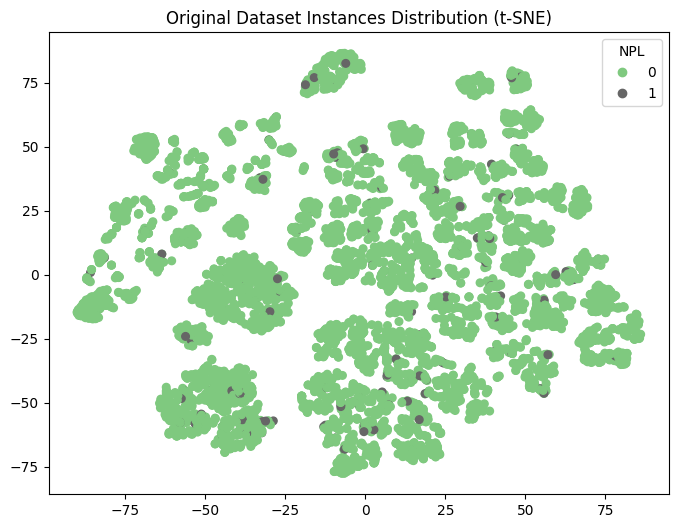

In [56]:
# Plotting the instances distribution.
import matplotlib.pyplot as plt

target = np.array(train_num.select('NPL').collect()).astype('int').flatten()
fig = plt.figure(figsize=(8, 6))
scatter = plt.scatter(array[:,0], array[:,1], c=target, s=30,
           cmap='Accent')

plt.title('Original Dataset Instances Distribution (t-SNE)')
plt.legend(*scatter.legend_elements(), title='NPL')

<div> 
    <ul style='font-size:20px'> 
        <li> 
            It must be disappointing to see such inconsistent distribution. We positively cannot expect nothing great from methods such as Linear SVM
            or even tree-based algorithms with such dataset.
        </li>
        <li> 
            What we can do is to attempt to filter out a handful of features that may be generating such instability.
        </li>
    </ul>
</div>

<p style='color:red'> Tentar fazer uma filtragem das features (correlação, wrapper...)</p>